# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("/home/felix/PycharmProjects/vae-wavefunctions/")
import numpy as np
from utils.WolffAlgorithm import WolffMonteCarlo
from utils.IsingData import generate_Ising_configurations

# Generate Ising Data

In [3]:
Ts = np.arange(1.5, 3.5, 0.1)
all_data_for_vae = generate_Ising_configurations(40, 1, Ts)

Generating samples for L = 40 at T = 1.500
Generating samples for L = 40 at T = 1.600
Generating samples for L = 40 at T = 1.700
Generating samples for L = 40 at T = 1.800
Generating samples for L = 40 at T = 1.900
Generating samples for L = 40 at T = 2.000
Generating samples for L = 40 at T = 2.100
Generating samples for L = 40 at T = 2.200
Generating samples for L = 40 at T = 2.300
Generating samples for L = 40 at T = 2.400
Generating samples for L = 40 at T = 2.500
Generating samples for L = 40 at T = 2.600
Generating samples for L = 40 at T = 2.700
Generating samples for L = 40 at T = 2.800
Generating samples for L = 40 at T = 2.900
Generating samples for L = 40 at T = 3.000
Generating samples for L = 40 at T = 3.100
Generating samples for L = 40 at T = 3.200
Generating samples for L = 40 at T = 3.300
Generating samples for L = 40 at T = 3.400


In [5]:
data = []
test_data = []
temperatures = []
for T in Ts:
    for i,snapshot in enumerate(all_data_for_vae['%.3f'%T]):        
        if i < 800:
            data.append(snapshot)
        else: 
            test_data.append(snapshot)
            temperatures.append(T)
    
data = np.array(data)
test_data = np.array(test_data)
print(data.shape)
print(test_data.shape)

(20, 1600)
(0,)


In [6]:
new_data = (np.array(data).astype("float32")+1)/2 
new_data.shape

(20, 1600)

In [7]:
new_test_data = (np.array(test_data).astype("float32")+1)/2 
new_test_data.shape

(0,)

# Define VAE

In [115]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [116]:
latent_dim = 1
encoder_inputs = keras.Input(shape=(1600))
x = layers.Dense(256, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1600)]       0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 256)          409856      ['input_15[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 1)            257         ['dense_18[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 1)            257         ['dense_18[0][0]']               
                                                                                            

In [117]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)

decoder_outputs = layers.Dense(1600, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_19 (Dense)            (None, 256)               512       
                                                                 
 dense_20 (Dense)            (None, 1600)              411200    
                                                                 
Total params: 411,712
Trainable params: 411,712
Non-trainable params: 0
_________________________________________________________________


In [118]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [119]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [120]:
vae.fit(new_data, epochs=100, batch_size=64)

Epoch 1/100
375/375 [==============================] - 4s 8ms/step - loss: 39.6728 - reconstruction_loss: 33.5299 - kl_loss: 1.9271
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 30.7820 - reconstruction_loss: 28.3638 - kl_loss: 2.0263
Epoch 3/100
375/375 [==============================] - 3s 9ms/step - loss: 30.7401 - reconstruction_loss: 28.3299 - kl_loss: 1.9694
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 30.1612 - reconstruction_loss: 28.0949 - kl_loss: 1.9207
Epoch 5/100
375/375 [==============================] - 3s 9ms/step - loss: 29.8637 - reconstruction_loss: 27.9415 - kl_loss: 1.8217
Epoch 6/100
375/375 [==============================] - 5s 13ms/step - loss: 29.3897 - reconstruction_loss: 27.7629 - kl_loss: 1.7185
Epoch 7/100
375/375 [==============================] - 4s 10ms/step - loss: 29.3663 - reconstruction_loss: 27.7435 - kl_loss: 1.6898
Epoch 8/100
375/375 [==============================] - 4s 9ms/step - loss:

# Analyze VAE result

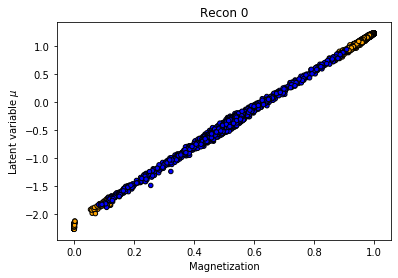

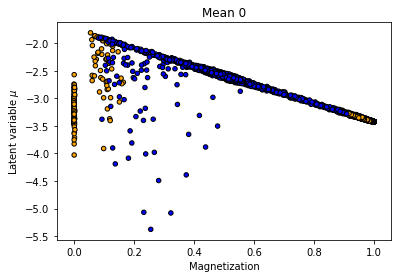

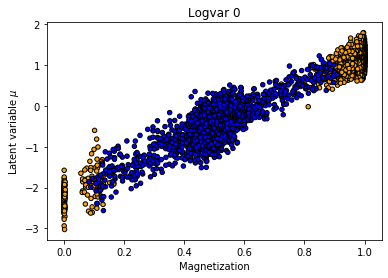

In [131]:
recon_x, mean, logvar = vae.encoder.predict(new_test_data, batch_size=64)
magnetization = np.mean(new_test_data, axis=1)


def draw_m(magnetization, mu, titel_str):
    
    colors = ['orange' if t < 2.27 else 'blue' for t in temperatures]

    fig, ax = plt.subplots()
    ax.scatter( magnetization, mu, c=colors, edgecolors='k', s = 20 )
    ax.set_xlabel("Magnetization")
    ax.set_ylabel("Latent variable $\mu$")
    plt.title(titel_str)

draw_m(magnetization,recon_x, "Recon 0")
draw_m(magnetization,mean, "Mean 0")
draw_m(magnetization,logvar, "Logvar 0")

# draw_m(magnetization,recon_x, 1, "Recon 1")
# draw_m(magnetization,mean, 1, "Mean 1")
# draw_m(magnetization,logvar, 1 , "Logvar 1")

In [132]:
mean_vs_T = []
magnetization_vs_T = []
for T in Ts:
    # Get all samples at this T
    samples_at_T = all_data_for_vae['%.3f'%T]
    # Get the mean for all of these
    recon_x, mean, logvar = vae.encoder.predict(samples_at_T, batch_size=64)
    
    mean_vs_T.append( np.mean(mean) )
    magnetization_vs_T.append( np.mean([ np.mean(t) for t in samples_at_T ]) )

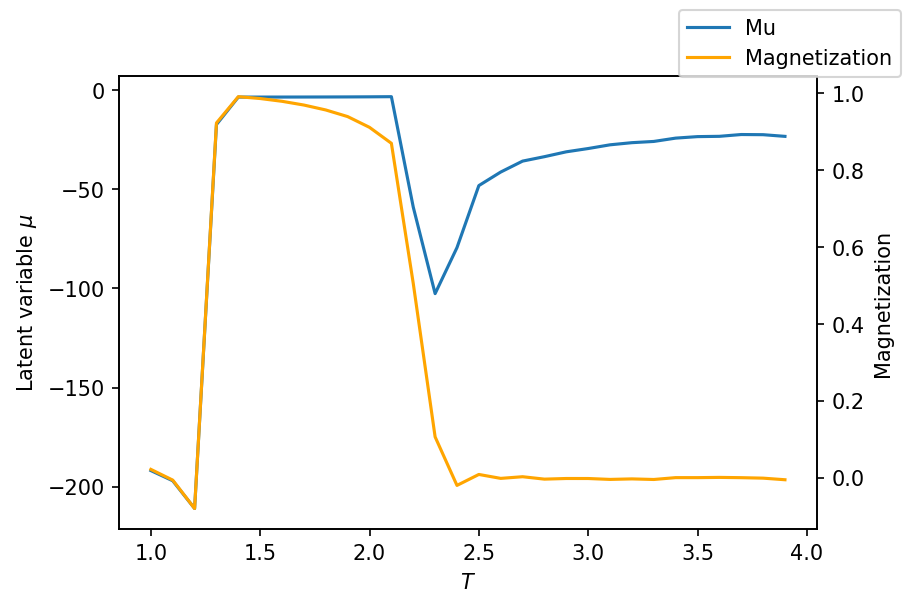

In [133]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ts, mean_vs_T, label="Mu")

ax2 = ax.twinx()
ax2.plot(Ts, magnetization_vs_T, c='orange', label= "Magnetization")

ax.set_xlabel("$T$")
ax.set_ylabel("Latent variable $\mu$")
ax2.set_ylabel("Magnetization")
fig.legend()
